# **Import Library Yang Dibutuhkan**


In [ ]:
# Libraries of commonly used
import os, shutil
import zipfile
import random
import shutil
from shutil import copyfile
import pathlib
import numpy as np
import pandas as pd
from google.colab import files

# Libraries for visualization
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for modeling and evaluation
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import keras 
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, BatchNormalization, SeparableConv2D
from keras.models import Sequential
from keras.utils import get_file

# Libraries for image data processing
import cv2
from PIL import Image

In [ ]:
print(tf.__version__)

2.9.2


In [ ]:
# Connect google drive with google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unrar or extract image dataset rar file
!unrar x '/content/drive/MyDrive/Orange-Ripeness-CNN/dataset.rar'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/Orange-Ripeness-CNN/dataset.rar

Creating    dataset                                                   OK
Creating    dataset/test                                              OK
Creating    dataset/test/blackspot                                    OK
Extracting  dataset/test/blackspot/pinta.jpg                               0%  OK 
Extracting  dataset/test/blackspot/pinta_preta_teste (1).jpg               0%  OK 
Extracting  dataset/test/blackspot/pinta_preta_teste (10).jpg              0%  OK 
Extracting  dataset/test/blackspot/pinta_preta_teste (100).jpg             0%  OK 
Extracting  dataset/test/blackspot/pinta_preta_teste (101).jpg             0%  OK 
Extracting  dataset/test/blackspot/pinta_preta_teste (102).jpg             0%  OK 
Extracting  dataset/test/blackspot/pinta_preta_teste (103).jpg             0%  

In [ ]:
# Define training and test directories
TRAIN_DIR = 'dataset/train/'
TEST_DIR = 'dataset/test/'

# Set the size of the image size (its width and height)
IMAGE_SIZE = 150
# Set the number of batch sizes
BATCH_SIZE = 32
# Set the number of epochs
EPOCHS = 50

# Data Augmentasi

Untuk memaksimalkan hasil pelatihan, dapat "memperbesar" keseluruhan kumpulan data melalui sejumlah transformasi acak, sehingga model tidak akan pernah melihat dua kali gambar yang serupa. Ini dapat membantu mencegah terjadinya overfitting dan membantu model menggeneralisasi lebih baik.

Hal tersebut dapat dilakukan dengan melakukan data augmentasi pada gambar yang terdiri dari :
- `rescale` = 1./255. Berfungsi berfungsi untuk mengubah ukuran data piksel RGB
gambar (0-255) menjadi rentang angka (0-1) untuk memudahkan proses
training data.
- `width_shift_range`= 0.2. Berfungsi untuk mengatur posisi gambar pada lebar
gambar, angka 0.2 menunjukkan bahwa citra dapat secara acak berada
maksimal 20% dari samping atau lebar awal citra gambar.
- `height_shift_range` = 0.2. Berfungsi untuk mengatur posisi gambar pada tinggi
gambar, angka 0.2 menunjukkan bahwa citra dapat secara acak berada
maksimal 20% dari atas bawah atau tinggi awal citra gambar. 
- `shear_range`= 0.2. Merupakan sudut geser dalam arah berlawanan arah jarum
jam dalam derajat.
- `zoom_range`= [0.5, 1.0]. Berfungsi untuk membesarkan citra gambar secara acak, 0.5 dan 1.0 menunjukkan intensitas pembesaran pada citra gambar.
- `rotation_range`= 90. Berfungsi untuk mengubah rotasi gambar secara acak,
angka 90 menunjukkan besaran derajat rotasi terhadap citra gambar.
- `horizontal_flip`= True. Berfungsi untuk membalik secara horizontal citra
gambar dengan acak, di atur dengan nilai benar.
- `vertical_flip`= True. Berfungsi untuk membalik secara vertikal citra gambar
dengan acak, di atur dengan nilai benar.
- `fill_mode`. Fill_mode berfungsi untuk mengisi wilayah atau gambar yang tidak
memiliki nilai. Terdapat 4 (empat) jenis fill_mode, yaitu nearest, reflect,
wrap, dan constant.
    1. Nearest: nilai piksel terdekat dari wilayah yang tidak memiliki nilai
       dipilih dan diulang. Misalnya, aaaaaaaa | abcd | dddddddd.
    2. Reflect: nilai piksel yang digunakan untuk mengisi wilayah yang
       tidak memiliki nilai dibalik dari nilai yang ada. Misalnya, abcddcba
       | abcd | dcbaabcd.
    3. Wrap: nilai piksel yang ada disalin tanpa dibalik untuk menjaga agar
       urutannya tidak berubah. Misalnya, abcdabcd | abcd | abcdabcd.
    4. Constant: nilai piksel pada mode ini ditentukan oleh cval argument
       dengan nilai konstan.
- `validation_split`= 0.2. Berfungsi untuk membagi data training ke set validasi, dimana set validasi berisikan 20% dari set pelatihan.


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2,
    zoom_range=[0.5, 1.0], 
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Image Data Generator

Pada TensorFlow dapat melakukan nya melalui kelas `tf.keras.preprocessing.image.ImageDataGenerator`. Kelas ini memungkinkan untuk dapat melakukan:
- Konfigurasikan transformasi acak dan operasi normalisasi yang akan dilakukan pada data gambar selama pelatihan
- Instantiate generator dari kumpulan gambar yang diperbesar (dan labelnya) melalui `.flow(data, labels)` atau `.flow_from_directory(directory)`. Generator ini kemudian dapat digunakan dengan metode model `tf.keras` yang menerima generator data sebagai input, `fit`, `evaluate`, dan `predict`

Persiapkan data pelatihan dan validasi, untuk memulai menggunakan `.flow_from_directory()` yang menghasilkan kumpulan data gambar beserta labelnya langsung pada folder masing-masing dengan mengatur ukuran `WIDTH` dan `HEIGHT`, ukuran `BATCH SIZE` yang telah ditentukan sebelumnya dan mode kelas nya. Disini kita menggunakan mode kelas `"categorical"` karena jumlah kelas yang  digunakan lebih dari 2.

In [ ]:
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    color_mode="rgb",
                                                    target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                         batch_size=BATCH_SIZE,
                                                         color_mode="rgb",
                                                         target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                         class_mode='categorical')

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  color_mode="rgb",
                                                  target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                  class_mode='categorical')

Found 1164 images belonging to 4 classes.
Found 1164 images belonging to 4 classes.
Found 626 images belonging to 4 classes.


# Callbacks

In [ ]:
# Define callbacks to avoid overfitting when training
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 98):
      print("\nReached 98% accuracy. Stop Training")
      self.model.stop_training = True

callbacks = myCallback()

# Training Model CNN Dengan Data Pelatihan

In [ ]:
####################### Init sequential model ##################################
model_quality = Sequential()

######################### Input layer with Fully Connected Layer ################################
# Input Layer
model_quality.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(150,150,3)))
model_quality.add(MaxPooling2D((2, 2)))
# Convolutional 2D Layer 1
model_quality.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model_quality.add(MaxPooling2D((2, 2)))
# Convolutional 2D Layer 2
model_quality.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model_quality.add(MaxPooling2D((2, 2)))
# Flatten Layer
model_quality.add(Flatten())
# Dense Layer
model_quality.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# Output Layer 
model_quality.add(Dense(4, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_quality.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
print(model_quality.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

# **Menjalankan Training Dengan Model CNN**

In [ ]:
%time
# Fitting / training model
history_quality = model_quality.fit(train_generator,
                                    epochs=EPOCHS,
                                    verbose=1,
                                    callbacks=[callbacks],
                                    validation_data=validation_generator)

Epoch 1/50
37/37 [==============================] - 38s 799ms/step - loss: 1.0547 - accuracy: 0.7165 - val_loss: 0.3173 - val_accuracy: 0.8239
Epoch 2/50
37/37 [==============================] - 29s 780ms/step - loss: 0.2660 - accuracy: 0.8711 - val_loss: 0.2325 - val_accuracy: 0.8771
Epoch 3/50
37/37 [==============================] - 29s 796ms/step - loss: 0.2471 - accuracy: 0.8797 - val_loss: 0.2314 - val_accuracy: 0.8763
Epoch 4/50
37/37 [==============================] - 31s 837ms/step - loss: 0.2274 - accuracy: 0.8918 - val_loss: 0.2242 - val_accuracy: 0.8823
Epoch 5/50
37/37 [==============================] - 28s 771ms/step - loss: 0.2131 - accuracy: 0.8918 - val_loss: 0.1618 - val_accuracy: 0.9270
Epoch 6/50
37/37 [==============================] - 28s 772ms/step - loss: 0.2351 - accuracy: 0.8789 - val_loss: 0.1898 - val_accuracy: 0.9098
Epoch 7/50
37/37 [==============================] - 28s 762ms/step - loss: 0.1665 - accuracy: 0.9149 - val_loss: 0.1586 - val_accuracy: 0.9192

# Grafik Loss dan Accuracy

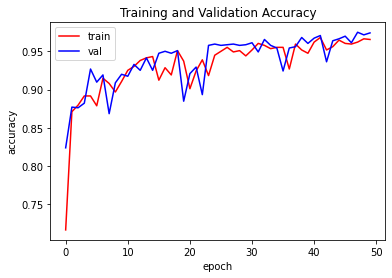

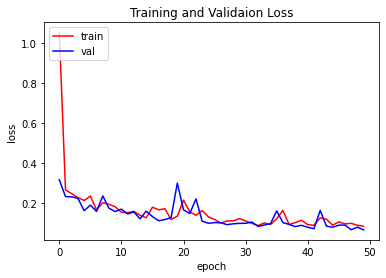

In [ ]:
acc = history_quality.history['accuracy']
val_acc = history_quality.history['val_accuracy']
loss = history_quality.history['loss']
val_loss = history_quality.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

# Evaluasi Model Dengan Data Pengujian

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model_quality.evaluate(test_generator,steps = (nb_samples), verbose=0)
print('Accuracy test: ',acc)
print('Loss test: ',loss)

Accuracy test:  0.97444087266922
Loss test:  0.07283521443605423


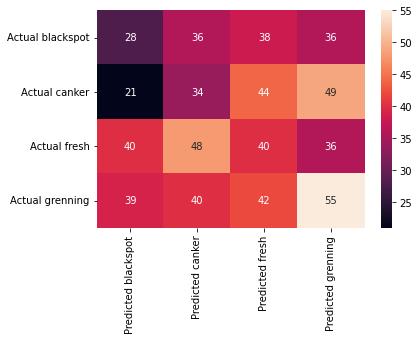

In [ ]:
test_generator.reset()

preds = model_quality.predict(test_generator,verbose=0)
test_labels = [np.argmax(pred) for pred in preds]

cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, 
                                        test_labels, labels=[0, 1, 2, 3]),
                                        index=["Actual blackspot", "Actual canker",
                                               "Actual fresh", "Actual grenning"],
                                        columns=["Predicted blackspot", "Predicted canker", 
                                                 "Predicted fresh", "Predicted grenning"])
sns.heatmap(cm,annot=True,fmt="d")
plt.show()

In [ ]:
model_quality.save('orange-quality-model.h5')

In [ ]:
quality_map = {v: k for k, v in train_generator.class_indices.items()}
print(train_generator.class_indices)
print(quality_map)

{'blackspot': 0, 'canker': 1, 'fresh': 2, 'grenning': 3}
{0: 'blackspot', 1: 'canker', 2: 'fresh', 3: 'grenning'}


# **Prediksi Dengan Data Gambar Baru**

Saving fresca (164).png to fresca (164).png


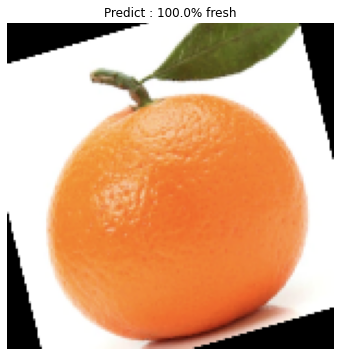

In [ ]:
model_quality = tf.keras.models.load_model('orange-quality-model.h5')

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(150, 150), interpolation="nearest")
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  images = np.vstack([img])

  classes = list(train_generator.class_indices.keys())
  pred = model_quality.predict(images, verbose=0)
  index = np.argmax(pred[0])
  probability = round(pred[0][index]*100, 2)
  
  plt.figure(figsize=(6,6))
  plt.axis('off')
  title = f'Predict : {probability}% {classes[index]}'
  plt.title(title)  
  plt.imshow(np.squeeze(images))
  plt.show()  

Saving pinta_preta_teste (206).jpg to pinta_preta_teste (206).jpg


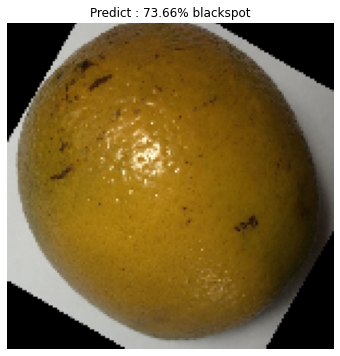

In [ ]:
model_quality = tf.keras.models.load_model('orange-quality-model.h5')

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(150, 150), interpolation="nearest")
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  images = np.vstack([img])

  classes = list(train_generator.class_indices.keys())
  pred = model_quality.predict(images, verbose=0)
  index = np.argmax(pred[0])
  probability= round(pred[0][index]*100, 2)
  
  plt.figure(figsize=(6,6))
  plt.axis('off')
  title = f'Predict : {probability}% {classes[index]}'
  plt.title(title)  
  plt.imshow(np.squeeze(images))
  plt.show()  

Saving grenning (120).jpg to grenning (120).jpg


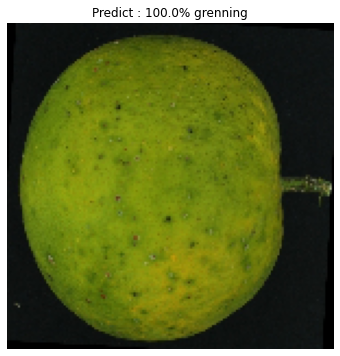

In [ ]:
model_quality = tf.keras.models.load_model('orange-quality-model.h5')

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(150, 150), interpolation="nearest")
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  images = np.vstack([img])

  classes = list(train_generator.class_indices.keys())
  pred = model_quality.predict(images, verbose=0)
  index = np.argmax(pred[0])
  probability= round(pred[0][index]*100, 2)
  
  plt.figure(figsize=(6,6))
  plt.axis('off')
  title = f'Predict : {probability}% {classes[index]}'
  plt.title(title)  
  plt.imshow(np.squeeze(images))
  plt.show()  

Saving cancro_teste (106).jpg to cancro_teste (106).jpg


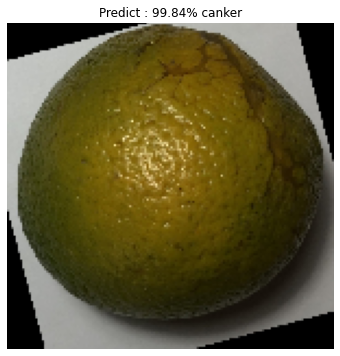

In [ ]:
model_quality = tf.keras.models.load_model('orange-quality-model.h5')

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(150, 150), interpolation="nearest")
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  images = np.vstack([img])

  classes = list(train_generator.class_indices.keys())
  pred = model_quality.predict(images, verbose=0)
  index = np.argmax(pred[0])
  probability= round(pred[0][index]*100, 2)
  
  plt.figure(figsize=(6,6))
  plt.axis('off')
  title = f'Predict : {probability}% {classes[index]}'
  plt.title(title)  
  plt.imshow(np.squeeze(images))
  plt.show()  